In [1]:
import seaborn as sns
import pandas as pd
import scipy.stats as st
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings

col = sns.color_palette("husl", 8)
warnings.filterwarnings('ignore')

In [4]:
title = True
persist = True

def plot(xs, means, q1, q3, names, xlab, ylab, savepath=None, legloc="lower right", title=None):
    
    plt.figure(figsize=(10,5))
    
    ax1 = sns.lineplot(xs[0], means[0], linewidth=2, color="#F9766D", label=names[0])
    ax1.fill_between(xs[0], q1[0], q3[0], alpha=0.35, color="#F9766D") 
    ax2 = sns.lineplot(xs[1], means[1], linewidth=2, color=col[6], label=names[1])
    ax2.fill_between(xs[1], q1[1], q3[1], alpha=0.35, color=col[6]) 

    plt.yticks(fontsize="16")
    plt.xticks(fontsize="16")
    if title:
        plt.title(title)

    plt.ylabel(ylab, fontsize="18")
    plt.xlabel(xlab, fontsize="18")
    plt.legend()
    plt.legend(loc=legloc, fontsize="16")
    
    sns.despine(left=True, bottom=True)

    if persist:
        plt.savefig(f'{savepath}.png', dpi=300)

def get_stats_by_group(df, value_attr, groupby_attr, bounding_stats="ci", ci_level=.95):
    
    stats = df.groupby(groupby_attr).describe()
    x = stats.index
    mean = stats[(value_attr, 'mean')]
    mean.name = value_attr

    lower_bounds = []
    upper_bounds = []
    if bounding_stats == "ci":
        cis = []
        for _,data in df.groupby(groupby_attr):
            cis.append(st.t.interval(alpha=ci_level, df=len(data)-1, loc=np.mean(data[value_attr]), scale=st.sem(data[value_attr])))
        lower_bounds = [i[0] for i in cis]
        upper_bounds = [i[1] for i in cis]
    elif bounding_stats == "std":
        lower_bounds = mean - stats[(value_attr, 'std')]
        upper_bounds = mean + stats[(value_attr, 'std')]
    return x, mean, (lower_bounds, upper_bounds)

def get_relative_to_first_per_group(df, rel_attr, group_by_first, first_attr):
    return df[rel_attr] /df.groupby(group_by_first)[first_attr].transform('first')

## Experiment 1: Objective development over generations (avg. plots)
### 1) Absolute development

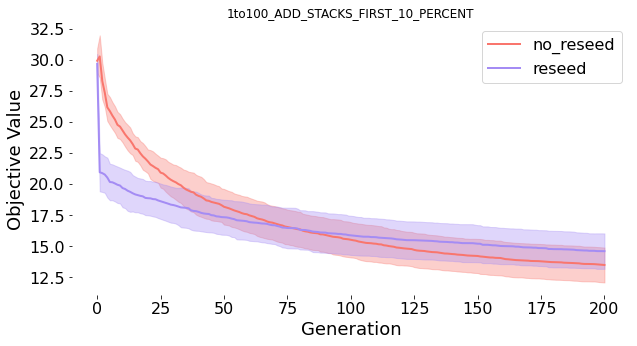

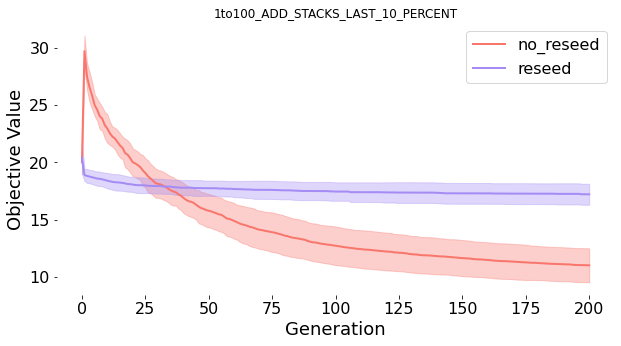

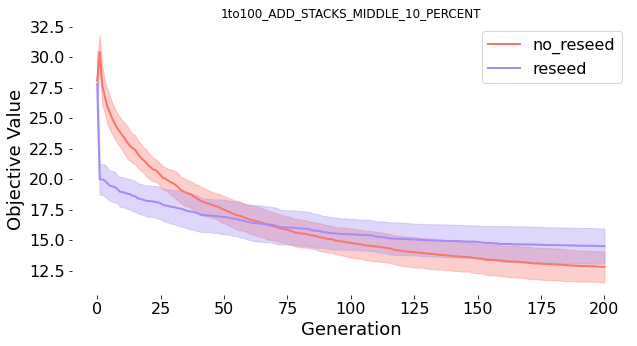

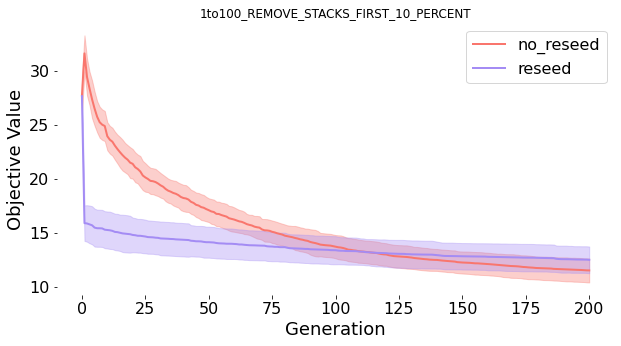

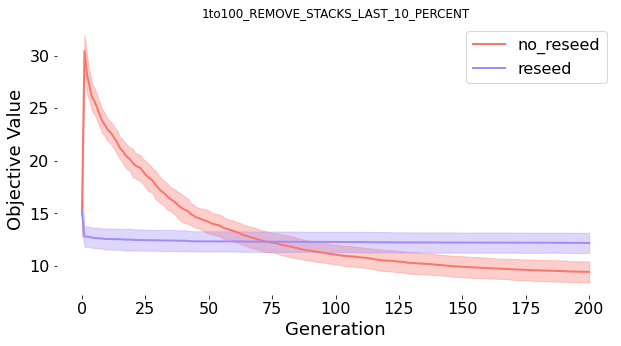

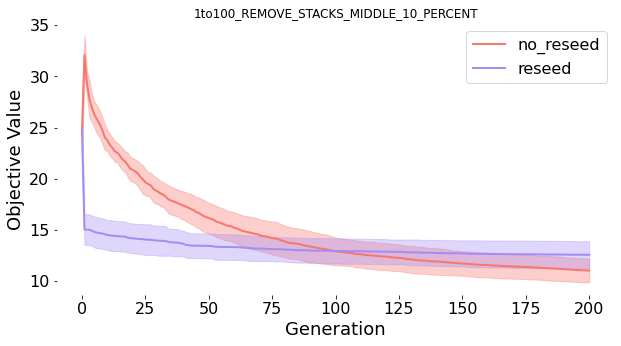

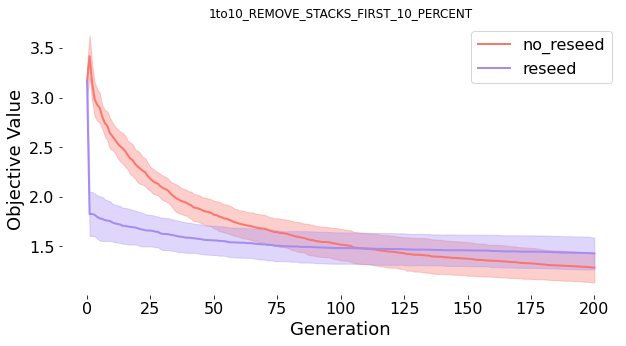

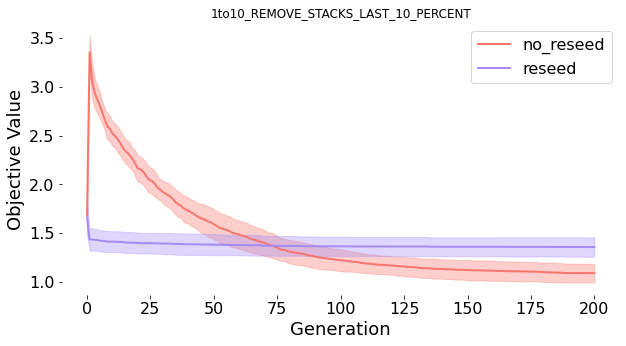

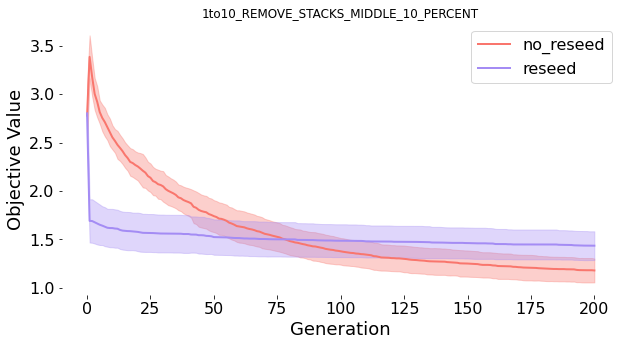

In [5]:
base_dir = os.path.join("exp1", "fixedPlanLength", "recording_best_objective")
files = os.listdir(base_dir)
for f in files:
    df = pd.read_csv(os.path.join(base_dir, f))
    df["generation"] = df["evaluations"] / 100
    case_name = f.split("_")[0] + "_" + f.split("@")[1].split("_errPerDisturbance-5")[0]
    df_no_reseed = df.loc[df["variant"] == "NSGAII_PlanningStrategy-ReplanningStrategy_0"]
    df_reseed = df.loc[df["variant"] == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1"]

    x1, mean1, bounds1 = get_stats_by_group(df_no_reseed,"objective_value", "generation", bounding_stats="std")
    x2, mean2, bounds2 = get_stats_by_group(df_reseed, "objective_value", "generation", bounding_stats="std")

    plot([x1, x2], [mean1, mean2], [bounds1[0], bounds2[0]], [bounds1[1], bounds2[1]], [ "no_reseed", "reseed"],
            "Generation", "Objective Value", legloc="upper right", savepath=case_name, title=case_name)

### 2) Relative obj. improvement (rel. to input model standard deviation/objective)

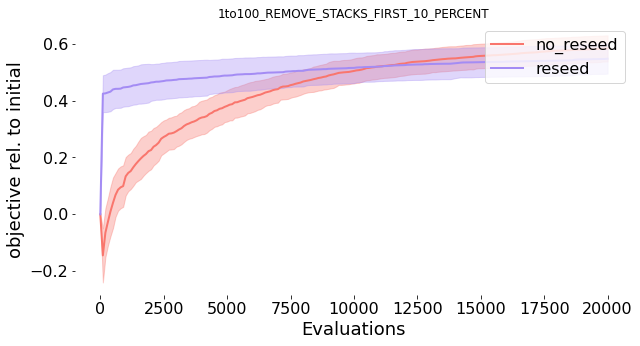

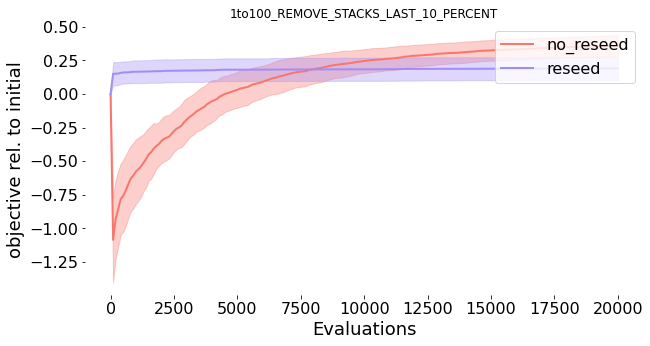

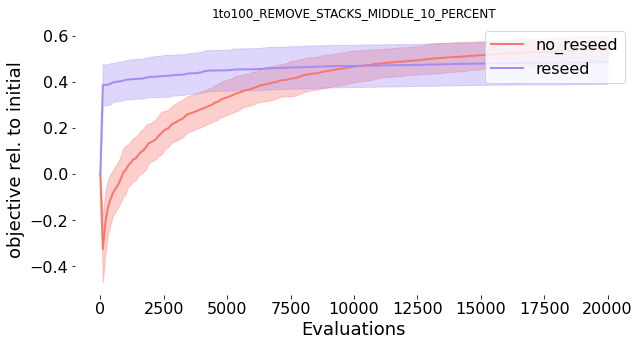

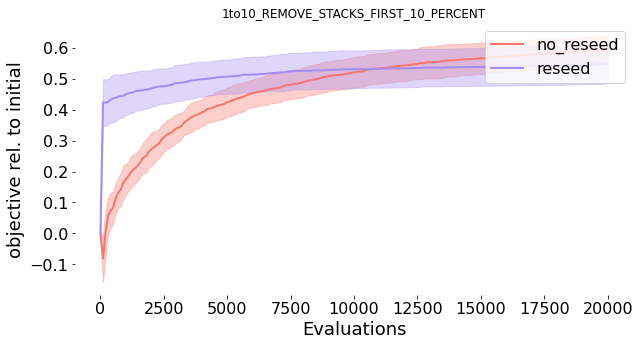

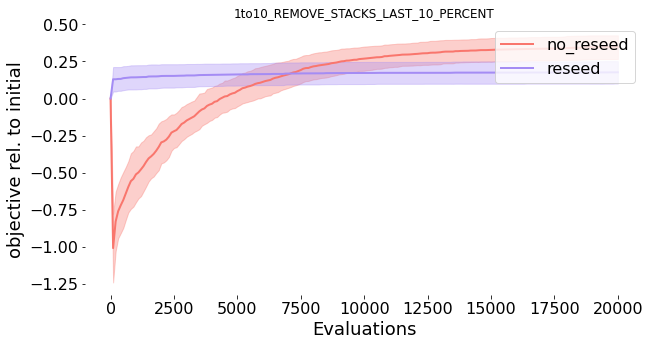

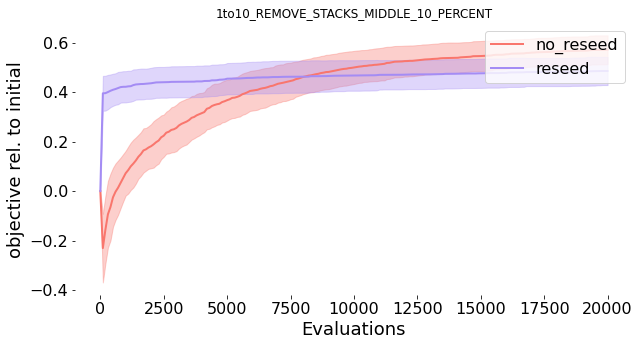

In [52]:
base_dir = os.path.join("exp1", "fixedPlanLength", "recording_best_objective")
files = os.listdir(base_dir)
for f in files:
    df = pd.read_csv(os.path.join(base_dir, f))
    case_name = f.split("_")[0] + "_" + f.split("@")[1].split("_errPerDisturbance-5")[0]
    df_rep = df.loc[df["variant"] == "NSGAII_PlanningStrategy-ReplanningStrategy_0"]
    df_reseed = df.loc[df["variant"] == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1"]

    df_rep = df_rep.assign(obj_impr=1- get_relative_to_first_per_group(df_rep, "objective_value", "run", "objective_value"))
    df_reseed = df_reseed.assign(obj_impr=1- get_relative_to_first_per_group(df_reseed, "objective_value", "run", "objective_value"))
    
    x1, mean1, bounds1 = get_stats_by_group(df_rep,"obj_impr", "evaluations", bounding_stats="std")
    x2, mean2, bounds2 = get_stats_by_group(df_reseed, "obj_impr", "evaluations", bounding_stats="std")

    plot([x1, x2], [mean1, mean2], [bounds1[0], bounds2[0]], [bounds1[1], bounds2[1]], [ "no_reseed", "reseed"],
            "Evaluations", "objective rel. to initial", legloc="upper right", savepath=None, title=case_name)

## Experiment 1: Time over generations (avg. plots)


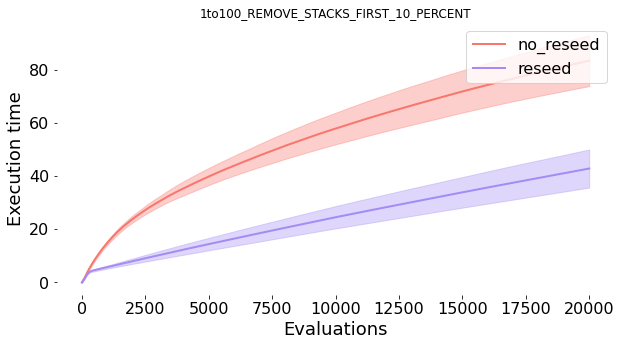

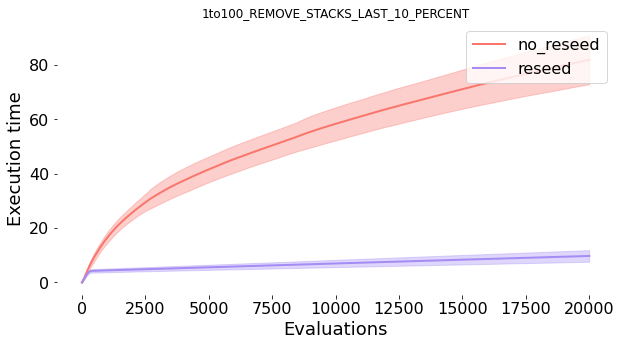

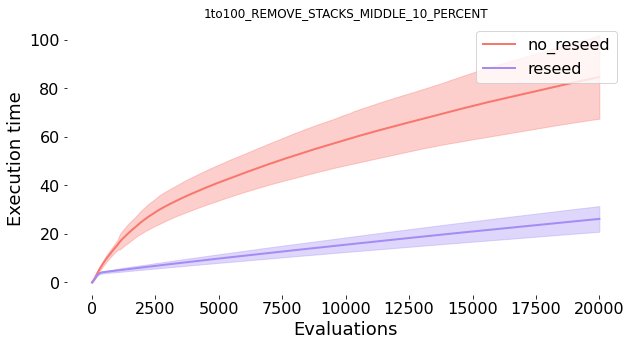

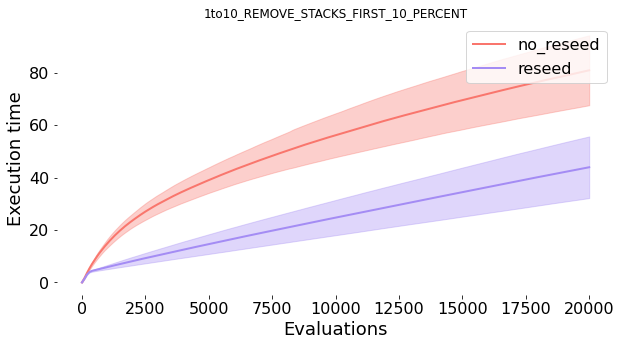

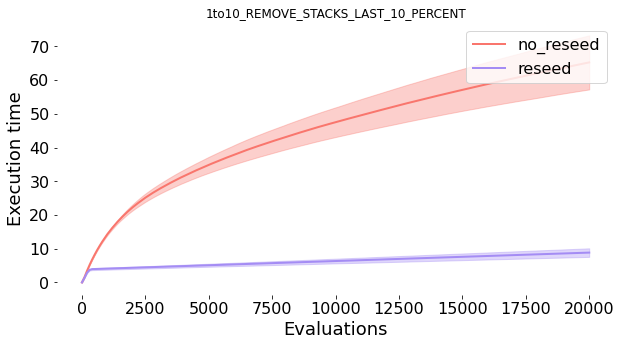

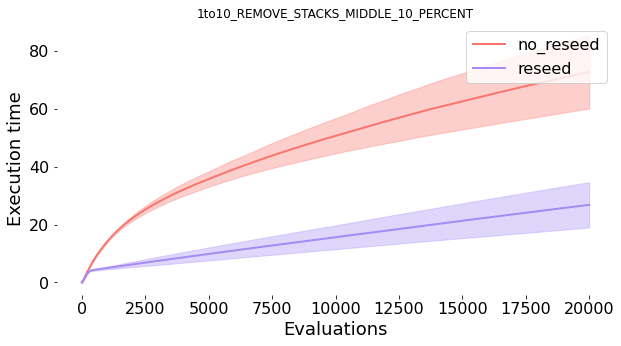

In [53]:
base_dir = os.path.join("exp1", "fixedPlanLength", "recording_best_objective")
files = os.listdir(base_dir)
for f in files:
    df = pd.read_csv(os.path.join(base_dir, f))
    case_name = f.split("_")[0] + "_" + f.split("@")[1].split("_errPerDisturbance-5")[0]
    df_no_reseed = df.loc[df["variant"] == "NSGAII_PlanningStrategy-ReplanningStrategy_0"]
    df_reseed = df.loc[df["variant"] == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1"]

    x1, mean1, bounds1 = get_stats_by_group(df_no_reseed,"seconds", "evaluations", bounding_stats="std")
    x2, mean2, bounds2 = get_stats_by_group(df_reseed, "seconds", "evaluations", bounding_stats="std")

    plot([x1, x2], [mean1, mean2], [bounds1[0], bounds2[0]], [bounds1[1], bounds2[1]], [ "no_reseed", "reseed"],
            "Evaluations", "Execution time", legloc="upper right", savepath=None, title=case_name)